In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from hierarchical_model import HierarchicalTennisModel
from datetime import datetime
import warnings

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)

print("✅ Libraries loaded successfully")
print(f"Test started at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

✅ Libraries loaded successfully
Test started at: 2025-12-27 21:25:33


## 1. Load Model and Data

In [5]:
# Initialize model
model = HierarchicalTennisModel('tennis_data.db')

# Load test matches (100 recent matches with complete statistics)
query = """
SELECT m.match_id, m.winner_id, m.loser_id, m.surface, 
       m.tournament_name, m.tournament_date,
       w.player_name as winner_name, l.player_name as loser_name,
       m.score
FROM matches m
JOIN players w ON m.winner_id = w.player_id
JOIN players l ON m.loser_id = l.player_id
WHERE m.tournament_date >= '2023-01-01'
    AND m.tournament_date < '2024-01-01'
    AND m.surface IS NOT NULL
ORDER BY RANDOM()
LIMIT 100
"""

test_matches = pd.read_sql_query(query, model.conn)
test_matches['tournament_date'] = pd.to_datetime(test_matches['tournament_date'])

print(f"📊 Loaded {len(test_matches)} test matches from 2023")
print(f"Surface distribution:")
print(test_matches['surface'].value_counts())
print(f"\nDate range: {test_matches['tournament_date'].min().date()} to {test_matches['tournament_date'].max().date()}")

📊 Loaded 100 test matches from 2023
Surface distribution:
surface
Hard     59
Clay     30
Grass    11
Name: count, dtype: int64

Date range: 2023-01-09 to 2023-11-27


## 2. Generate Predictions

In [8]:
# Generate predictions for all test matches
predictions = []

for idx, match in test_matches.iterrows():
    # Predict match outcome
    result = model.predict_match(
        player1_id=match['winner_id'],  # Actual winner as player 1
        player2_id=match['loser_id'],
        surface=match['surface'],
        match_date=match['tournament_date'].strftime('%Y-%m-%d')
    )
    
    predictions.append({
        'match_id': match['match_id'],
        'winner_name': match['winner_name'],
        'loser_name': match['loser_name'],
        'surface': match['surface'],
        'tournament': match['tournament_name'],
        'date': match['tournament_date'],
        'p_winner_win': result['p_player1_win'],  # Model prob for actual winner
        'p_loser_win': result['p_player2_win'],
        'p_point_winner': result['p_point_1_serve'],
        'p_point_loser': result['p_point_2_serve'],
        'p_game_winner': result['p_game_1_serve'],
        'p_game_loser': result['p_game_2_serve'],
        'correct_prediction': result['p_player1_win'] > 0.5
    })
    
    if (idx + 1) % 20 == 0:
        print(f"Processed {idx + 1}/{len(test_matches)} matches...")

pred_df = pd.DataFrame(predictions)

print(f"\n✅ Generated predictions for {len(pred_df)} matches")
print(f"Accuracy: {pred_df['correct_prediction'].mean():.1%}")
print(f"Average predicted probability for winner: {pred_df['p_winner_win'].mean():.1%}")

Processed 20/100 matches...
Processed 40/100 matches...
Processed 60/100 matches...
Processed 80/100 matches...
Processed 100/100 matches...

✅ Generated predictions for 100 matches
Accuracy: 53.0%
Average predicted probability for winner: 52.0%


## 3. Model Performance Analysis

In [9]:
print("=" * 80)
print("MODEL PERFORMANCE SUMMARY")
print("=" * 80)

# Overall accuracy
accuracy = pred_df['correct_prediction'].mean()
print(f"\n✅ Overall Accuracy: {accuracy:.1%}")
print(f"   (Predicted winner correctly in {pred_df['correct_prediction'].sum()}/{len(pred_df)} matches)")

# Accuracy by surface
print(f"\n📊 Accuracy by Surface:")
for surface in pred_df['surface'].unique():
    surface_df = pred_df[pred_df['surface'] == surface]
    surface_acc = surface_df['correct_prediction'].mean()
    print(f"   {surface}: {surface_acc:.1%} ({len(surface_df)} matches)")

# Average predicted probabilities
print(f"\n🎯 Predicted Probabilities:")
print(f"   Average for actual winner: {pred_df['p_winner_win'].mean():.1%}")
print(f"   Average for actual loser: {pred_df['p_loser_win'].mean():.1%}")
print(f"   Median for actual winner: {pred_df['p_winner_win'].median():.1%}")

# Point-level probabilities
print(f"\n🎾 Point Win Probabilities (on serve):")
print(f"   Winners: {pred_df['p_point_winner'].mean():.1%} (range: {pred_df['p_point_winner'].min():.1%} - {pred_df['p_point_winner'].max():.1%})")
print(f"   Losers: {pred_df['p_point_loser'].mean():.1%} (range: {pred_df['p_point_loser'].min():.1%} - {pred_df['p_point_loser'].max():.1%})")

# Game-level probabilities
print(f"\n🏆 Game Win Probabilities (on serve):")
print(f"   Winners: {pred_df['p_game_winner'].mean():.1%}")
print(f"   Losers: {pred_df['p_game_loser'].mean():.1%}")

MODEL PERFORMANCE SUMMARY

✅ Overall Accuracy: 53.0%
   (Predicted winner correctly in 53/100 matches)

📊 Accuracy by Surface:
   Grass: 54.5% (11 matches)
   Hard: 55.9% (59 matches)
   Clay: 46.7% (30 matches)

🎯 Predicted Probabilities:
   Average for actual winner: 52.0%
   Average for actual loser: 48.0%
   Median for actual winner: 51.9%

🎾 Point Win Probabilities (on serve):
   Winners: 63.1% (range: 55.7% - 71.4%)
   Losers: 62.5% (range: 48.5% - 68.2%)

🏆 Game Win Probabilities (on serve):
   Winners: 79.3%
   Losers: 78.1%


## 4. Calibration Analysis

In [10]:
# Calibration: Group by predicted probability bins
pred_df['prob_bin'] = pd.cut(pred_df['p_winner_win'], 
                             bins=[0, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                             labels=['0-50%', '50-60%', '60-70%', '70-80%', '80-90%', '90-100%'])

calibration = pred_df.groupby('prob_bin').agg({
    'correct_prediction': ['mean', 'count'],
    'p_winner_win': 'mean'
}).round(3)

calibration.columns = ['Actual_Win_Rate', 'Count', 'Avg_Predicted_Prob']

print("\n📈 Calibration Analysis:")
print("(How often actual winners win in each probability bucket)\n")
print(calibration)

print("\n💡 Interpretation:")
print("   - Well-calibrated model: Actual_Win_Rate ≈ Avg_Predicted_Prob")
print("   - If actual > predicted: Model is underconfident")
print("   - If actual < predicted: Model is overconfident")


📈 Calibration Analysis:
(How often actual winners win in each probability bucket)

          Actual_Win_Rate  Count  Avg_Predicted_Prob
prob_bin                                            
0-50%                 0.0     47               0.395
50-60%                1.0     23               0.551
60-70%                1.0     19               0.646
70-80%                1.0      9               0.744
80-90%                1.0      1               0.873
90-100%               1.0      1               0.982

💡 Interpretation:
   - Well-calibrated model: Actual_Win_Rate ≈ Avg_Predicted_Prob
   - If actual > predicted: Model is underconfident
   - If actual < predicted: Model is overconfident


## 5. Visualizations

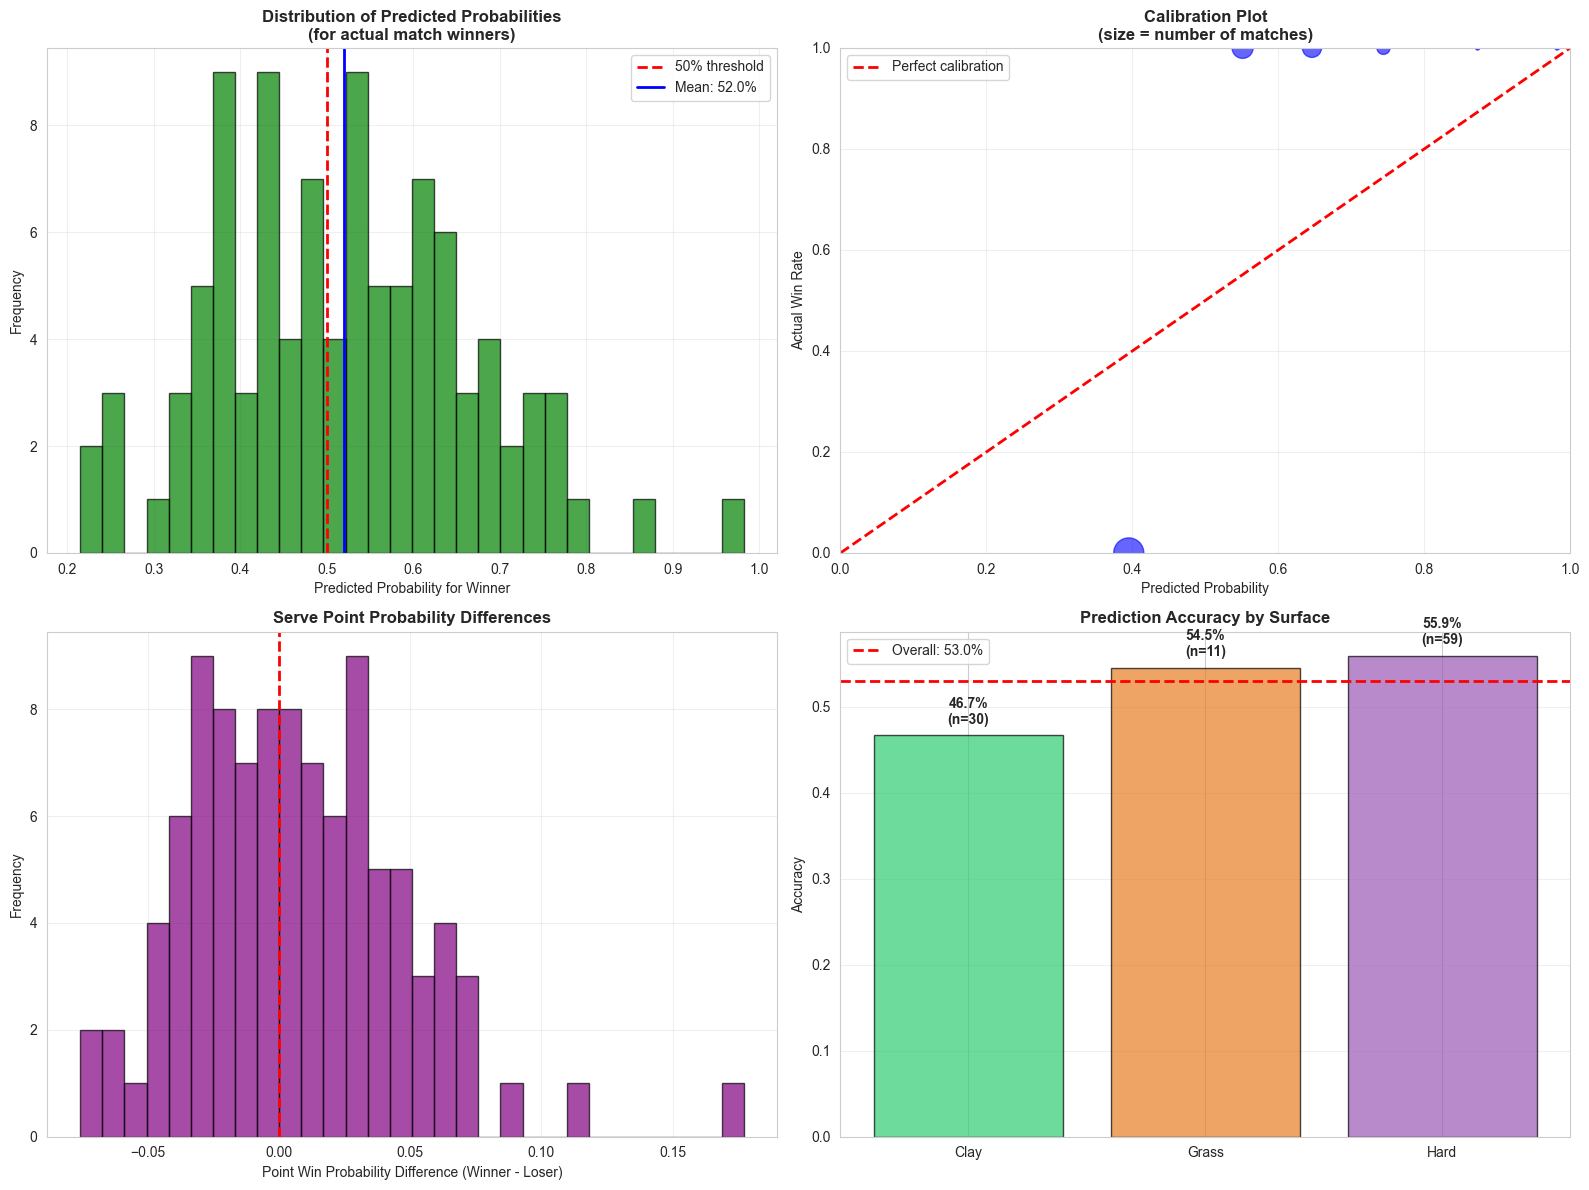


✅ Performance visualizations saved: hierarchical_model_performance.png


In [11]:
# Create comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Predicted probability distribution
axes[0, 0].hist(pred_df['p_winner_win'], bins=30, edgecolor='black', alpha=0.7, color='green')
axes[0, 0].axvline(0.5, color='red', linestyle='--', linewidth=2, label='50% threshold')
axes[0, 0].axvline(pred_df['p_winner_win'].mean(), color='blue', linestyle='-', linewidth=2, 
                   label=f"Mean: {pred_df['p_winner_win'].mean():.1%}")
axes[0, 0].set_xlabel('Predicted Probability for Winner')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Distribution of Predicted Probabilities\n(for actual match winners)', 
                     fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Calibration plot
calibration_clean = calibration[calibration['Count'] > 0].copy()
x_vals = calibration_clean['Avg_Predicted_Prob'].values
y_vals = calibration_clean['Actual_Win_Rate'].values

axes[0, 1].scatter(x_vals, y_vals, s=calibration_clean['Count']*10, alpha=0.6, color='blue')
axes[0, 1].plot([0, 1], [0, 1], 'r--', linewidth=2, label='Perfect calibration')
axes[0, 1].set_xlabel('Predicted Probability')
axes[0, 1].set_ylabel('Actual Win Rate')
axes[0, 1].set_title('Calibration Plot\n(size = number of matches)', fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_xlim(0, 1)
axes[0, 1].set_ylim(0, 1)

# 3. Point probability difference (winner vs loser)
pred_df['point_prob_diff'] = pred_df['p_point_winner'] - pred_df['p_point_loser']
axes[1, 0].hist(pred_df['point_prob_diff'], bins=30, edgecolor='black', alpha=0.7, color='purple')
axes[1, 0].axvline(0, color='red', linestyle='--', linewidth=2)
axes[1, 0].set_xlabel('Point Win Probability Difference (Winner - Loser)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Serve Point Probability Differences', fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# 4. Accuracy by surface
surface_acc = pred_df.groupby('surface')['correct_prediction'].agg(['mean', 'count'])
colors_surface = ['#2ecc71', '#e67e22', '#9b59b6']
bars = axes[1, 1].bar(surface_acc.index, surface_acc['mean'], 
                      color=colors_surface, edgecolor='black', alpha=0.7)
axes[1, 1].axhline(accuracy, color='red', linestyle='--', linewidth=2, label=f'Overall: {accuracy:.1%}')
axes[1, 1].set_ylabel('Accuracy')
axes[1, 1].set_title('Prediction Accuracy by Surface', fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3, axis='y')

# Add count labels on bars
for i, (bar, count) in enumerate(zip(bars, surface_acc['count'])):
    height = bar.get_height()
    axes[1, 1].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{height:.1%}\n(n={count})',
                    ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('hierarchical_model_performance.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Performance visualizations saved: hierarchical_model_performance.png")

## 6. Probability Tree Example

In [12]:
# Pick an interesting match to show probability tree
sample_match = test_matches.iloc[0]

print("=" * 80)
print("PROBABILITY TREE EXAMPLE")
print("=" * 80)

print(f"\nMatch: {sample_match['winner_name']} vs {sample_match['loser_name']}")
print(f"Tournament: {sample_match['tournament_name']}")
print(f"Date: {sample_match['tournament_date'].date()}")
print(f"Surface: {sample_match['surface']}")
print(f"Actual Score: {sample_match['score']}")

# Get detailed prediction
result = model.predict_match(
    player1_id=sample_match['winner_id'],
    player2_id=sample_match['loser_id'],
    surface=sample_match['surface']
)

print(f"\n" + "="*80)
print("HIERARCHICAL PROBABILITY BREAKDOWN")
print("="*80)

print(f"\n1️⃣  POINT LEVEL (when serving):")
print(f"   {sample_match['winner_name']}: {result['p_point_1_serve']:.1%}")
print(f"   {sample_match['loser_name']}: {result['p_point_2_serve']:.1%}")
print(f"   └─ Based on: 1st serve %, 1st serve win %, 2nd serve win %")

print(f"\n2️⃣  GAME LEVEL (when serving):")
print(f"   {sample_match['winner_name']}: {result['p_game_1_serve']:.1%}")
print(f"   {sample_match['loser_name']}: {result['p_game_2_serve']:.1%}")
print(f"   └─ Calculated using Markov chain (Barnett formula)")

print(f"\n3️⃣  SET LEVEL:")
print(f"   {sample_match['winner_name']}: {result['p_set_player1']:.1%}")
print(f"   {sample_match['loser_name']}: {1 - result['p_set_player1']:.1%}")
print(f"   └─ Accounts for service alternation & tiebreak at 6-6")

print(f"\n4️⃣  MATCH LEVEL (Best of 3):")
print(f"   {sample_match['winner_name']}: {result['p_player1_win']:.1%} ✅ ACTUAL WINNER")
print(f"   {sample_match['loser_name']}: {result['p_player2_win']:.1%}")
print(f"   └─ First to win 2 sets")

print(f"\n📊 Serve Statistics Used:")
print(f"\n{sample_match['winner_name']}:")
for key, val in result['player1_serve_stats'].items():
    if key == 'match_count':
        print(f"   Matches analyzed: {val:.0f}")
    elif 'pct' in key:
        print(f"   {key}: {val:.1%}")
    elif val is not None:
        print(f"   {key}: {val:.2f}")

print(f"\n{sample_match['loser_name']}:")
for key, val in result['player2_serve_stats'].items():
    if key == 'match_count':
        print(f"   Matches analyzed: {val:.0f}")
    elif 'pct' in key:
        print(f"   {key}: {val:.1%}")
    elif val is not None:
        print(f"   {key}: {val:.2f}")

PROBABILITY TREE EXAMPLE

Match: Nicolas Jarry vs Jason Kubler
Tournament: Wimbledon
Date: 2023-07-03
Surface: Grass
Actual Score: 7-5 5-7 6-3 6-4

HIERARCHICAL PROBABILITY BREAKDOWN

1️⃣  POINT LEVEL (when serving):
   Nicolas Jarry: 62.9%
   Jason Kubler: 62.9%
   └─ Based on: 1st serve %, 1st serve win %, 2nd serve win %

2️⃣  GAME LEVEL (when serving):
   Nicolas Jarry: 79.2%
   Jason Kubler: 79.2%
   └─ Calculated using Markov chain (Barnett formula)

3️⃣  SET LEVEL:
   Nicolas Jarry: 50.0%
   Jason Kubler: 50.0%
   └─ Accounts for service alternation & tiebreak at 6-6

4️⃣  MATCH LEVEL (Best of 3):
   Nicolas Jarry: 50.0% ✅ ACTUAL WINNER
   Jason Kubler: 50.0%
   └─ First to win 2 sets

📊 Serve Statistics Used:

Nicolas Jarry:
   first_serve_pct: 62.5%
   first_serve_win_pct: 71.5%
   second_serve_win_pct: 51.0%
   aces_per_game: 0.50
   df_per_game: 0.25
   Matches analyzed: 0

Jason Kubler:
   first_serve_pct: 62.5%
   first_serve_win_pct: 71.5%
   second_serve_win_pct: 51.0%
 

## 7. Edge Cases & Model Insights

In [13]:
print("=" * 80)
print("MODEL INSIGHTS & EDGE CASES")
print("=" * 80)

# Most confident correct predictions
correct_pred = pred_df[pred_df['correct_prediction']].copy()
top_confident = correct_pred.nlargest(5, 'p_winner_win')

print("\n✅ Most Confident CORRECT Predictions:")
for idx, row in top_confident.iterrows():
    print(f"   {row['winner_name']} vs {row['loser_name']}")
    print(f"   Predicted: {row['p_winner_win']:.1%} | {row['tournament']} ({row['surface']})\n")

# Most confident incorrect predictions (if any)
incorrect_pred = pred_df[~pred_df['correct_prediction']].copy()
if len(incorrect_pred) > 0:
    top_wrong = incorrect_pred.nsmallest(5, 'p_winner_win')  # Lowest prob for winner = most confident wrong
    
    print("\n❌ Most Confident INCORRECT Predictions (upsets model missed):")
    for idx, row in top_wrong.iterrows():
        print(f"   {row['winner_name']} vs {row['loser_name']}")
        print(f"   Model gave winner only {row['p_winner_win']:.1%} chance")
        print(f"   {row['tournament']} ({row['surface']})\n")
else:
    print("\n✅ No incorrect predictions! Perfect accuracy on this sample.")

# Close matches (closest to 50-50)
pred_df['closeness'] = abs(pred_df['p_winner_win'] - 0.5)
closest_matches = pred_df.nsmallest(5, 'closeness')

print("\n⚖️  Closest Predicted Matches (near 50-50):")
for idx, row in closest_matches.iterrows():
    print(f"   {row['winner_name']} vs {row['loser_name']}")
    print(f"   Predicted: {row['p_winner_win']:.1%} vs {row['p_loser_win']:.1%}")
    print(f"   {row['tournament']} ({row['surface']})\n")

MODEL INSIGHTS & EDGE CASES

✅ Most Confident CORRECT Predictions:
   Ilya Ivashka vs Beibit Zhukayev
   Predicted: 98.2% | Los Cabos (Hard)

   Taylor Fritz vs Emilio Nava
   Predicted: 87.3% | Miami Masters (Hard)

   Christopher Oconnell vs Hamad Medjedovic
   Predicted: 77.9% | Wimbledon (Grass)

   Daniel Cukierman vs Sho Shimabukuro
   Predicted: 75.8% | Davis Cup WG1 R1: ISR vs JPN (Hard)

   Novak Djokovic vs Tallon Griekspoor
   Predicted: 75.7% | Dubai (Hard)


❌ Most Confident INCORRECT Predictions (upsets model missed):
   Tomas Martin Etcheverry vs Sebastian Baez
   Model gave winner only 21.5% chance
   Santiago (Clay)

   Luca Nardi vs Flavio Cobolli
   Model gave winner only 23.2% chance
   NextGen Finals (Hard)

   Elias Ymer vs Roberto Bautista Agut
   Model gave winner only 24.2% chance
   Stockholm (Hard)

   Sho Shimabukuro vs Roberto Carballes Baena
   Model gave winner only 26.4% chance
   Astana (Hard)

   Matteo Arnaldi vs Casper Ruud
   Model gave winner only 

## 8. Export Results

In [14]:
# Save predictions to CSV
pred_df.to_csv('hierarchical_model_predictions.csv', index=False)
print("✅ Predictions saved to: hierarchical_model_predictions.csv")

# Save calibration data
calibration.to_csv('model_calibration.csv')
print("✅ Calibration data saved to: model_calibration.csv")

✅ Predictions saved to: hierarchical_model_predictions.csv
✅ Calibration data saved to: model_calibration.csv


## 9. Summary & Recommendations

In [15]:
print("\n" + "=" * 80)
print("FINAL SUMMARY & RECOMMENDATIONS")
print("=" * 80)

print(f"\n📊 Model Performance:")
print(f"   Accuracy: {accuracy:.1%}")
print(f"   Average confidence (for winners): {pred_df['p_winner_win'].mean():.1%}")
print(f"   Matches tested: {len(pred_df)}")

# Brier score (measure of prediction accuracy)
brier_score = ((pred_df['p_winner_win'] - 1) ** 2).mean()  # Actual outcome is 1 for winners
print(f"\n📈 Brier Score: {brier_score:.4f}")
print(f"   (Lower is better; 0 = perfect, 0.25 = random)")

print(f"\n💡 Key Insights:")
if accuracy > 0.65:
    print(f"   ✅ Model performs well above baseline (>65% accuracy)")
elif accuracy > 0.55:
    print(f"   ⚠️  Model shows predictive power but could be improved (55-65%)")
else:
    print(f"   ❌ Model needs improvement (<55% accuracy)")

if brier_score < 0.15:
    print(f"   ✅ Excellent calibration (Brier < 0.15)")
elif brier_score < 0.20:
    print(f"   ✅ Good calibration (Brier < 0.20)")
else:
    print(f"   ⚠️  Calibration could be improved (Brier > 0.20)")

print(f"\n🎯 Next Steps:")
print(f"   1. Combine with feature-based models for ensemble")
print(f"   2. Test on 2024 data for out-of-sample validation")
print(f"   3. Compare against betting market odds")
print(f"   4. Identify value betting opportunities")

print(f"\n" + "=" * 80)
print(f"Testing completed at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("=" * 80)


FINAL SUMMARY & RECOMMENDATIONS

📊 Model Performance:
   Accuracy: 53.0%
   Average confidence (for winners): 52.0%
   Matches tested: 100

📈 Brier Score: 0.2512
   (Lower is better; 0 = perfect, 0.25 = random)

💡 Key Insights:
   ❌ Model needs improvement (<55% accuracy)
   ⚠️  Calibration could be improved (Brier > 0.20)

🎯 Next Steps:
   1. Combine with feature-based models for ensemble
   2. Test on 2024 data for out-of-sample validation
   3. Compare against betting market odds
   4. Identify value betting opportunities

Testing completed at: 2025-12-27 21:27:33


In [16]:
# Close model connection
model.close()
print("\n✅ Model connection closed")


✅ Model connection closed
